# FIT1043 Introduction to Data Science, Assignment 2

<div style="text-align: right">Taaha Waseem</div>
<div style="text-align: right">28888286</div>
<div style="text-align: right">20th April 2021</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Introduction

The assignment focuses on the machine learning algorithm SVR or Support Vector Machine to classify essays into labels or scores depending on 17 features such as word count, average sentence length, type of word used etc. Not only does the assignment identify the accuracy and Quadratic Kapka Value of the model but also aims to predict scores for a dataset in order to complete in the in-class Kaggle Competition.

Outline:
1. Introduction
2. Supervised Learning
3. Classification
4. Kaggle Submission
5. Conclusion
6. References

### Importing Libraries

The first step is to import the library <b>pandas</b> which allows data manipulation and analysis. Importing this library would allow us to input CSV files and transform the data retreived into structures like <b>DataFrame</b> for further manipulation. Secondly, we import a library called <b>numpy</b> which allows us to manipulate the dataframe and test and training sets. From <b>sklearn</b>, we import <b>train_test_split</b> to divide dataset into train and test set, <b>StandardScaler</b> to scale the data amongst the columns, <b>SVR</b> to implement the Support Vector Regression Algorithm and lastly we import some libraries like <b>confusion_matrix</b> that help us evaluate the performance of the model. We also import a library called <b>matplotlib.pyplot</b> which allows us to plot the data into graphs and plots for better graphical representation of the data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline

### Reading the file

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/FIT1043-Essay-Features.csv')
dataset.describe()

,essayid,chars,words,commas,apostrophes,punctuations,avg_word_length,sentences,questions,avg_word_sentence,POS,POS/total_words,prompt_words,prompt_words/total_words,synonym_words,synonym_words/total_words,unstemmed,stemmed,score
count,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000
mean,905.27027,2101.745495,424.485736,14.667417,8.141141,0.47973,4.939762,19.704204,1.222973,23.884687,420.596542,0.989935,198.913664,0.469164,110.16967,0.263846,468.987988,455.507508,3.427177
std,526.68760,865.963750,171.873730,10.920781,6.124520,1.27168,0.231071,19.202731,1.847446,11.160020,170.985111,0.007308,82.729266,0.052466,43.96192,0.038870,159.447449,155.751220,0.774275
min,0.00000,169.000000,36.000000,0.000000,2.000000,0.00000,2.231322,0.000000,0.000000,1.084112,35.647059,0.924771,14.000000,0.288889,11.00000,0.027299,48.000000,50.000000,1.000000
25%,442.75000,1527.250000,310.000000,7.000000,4.000000,0.00000,4.791679,13.000000,0.000000,19.142857,305.406284,0.987758,144.000000,0.435709,81.00000,0.238423,361.000000,350.750000,3.000000
50%,914.50000,2029.500000,411.000000,13.000000,6.000000,0.00000,4.946059,18.000000,1.000000,22.030331,406.982869,0.991572,193.000000,0.465852,107.50000,0.262872,463.000000,448.000000,3.000000
75%,1369.75000,2613.500000,525.000000,21.000000,11.000000,0.00000,5.092938,24.000000,2.000000,26.048234,520.739458,0.994425,246.000000,0.500000,134.00000,0.288277,581.000000,561.250000,4.000000
max,1799.00000,6142.000000,1170.000000,72.000000,51.000000,26.00000,5.681429,642.000000,17.000000,303.000000,1158.984563,1.000000,669.000000,0.961207,355.00000,0.465517,750.000000,750.000000,6.000000


The dataset contains a total of 1332 rows and 19 columns. The mean, standard deviation and many more metrics are identified. It can be seen that the mean of score is 3.427 with min value 1 and max value 6 as it should be. If there was exactly one record for each score, the mean would be equal to (1+2+3+4+5+6)/6 = 3.5 which is very close to what we got. It can also be seen that for some columns, the mean is very high while for others, it is very low.

In [ ]:
for i in range(1,7):
    print("Number of Rows for Score = " + str(i) + ": " + str(dataset[dataset['score'] ==i].shape[0]))

Number of Rows for Score = 1: 18
Number of Rows for Score = 2: 110
Number of Rows for Score = 3: 557
Number of Rows for Score = 4: 583
Number of Rows for Score = 5: 60
Number of Rows for Score = 6: 4


With further analysis, we can see the number of rows that exist in the dataframe for each score. The numbers show clear disparity amongst the scores and hence we can claim that the dataset is unfair. Scores 1, 2, 5 and 6 do not have enough records compared to rows with score 3 and 4. This could also result into a lower accuracy of the entire model, particulary with scores that are not 3 or 4.

## 2. Supervised Learning

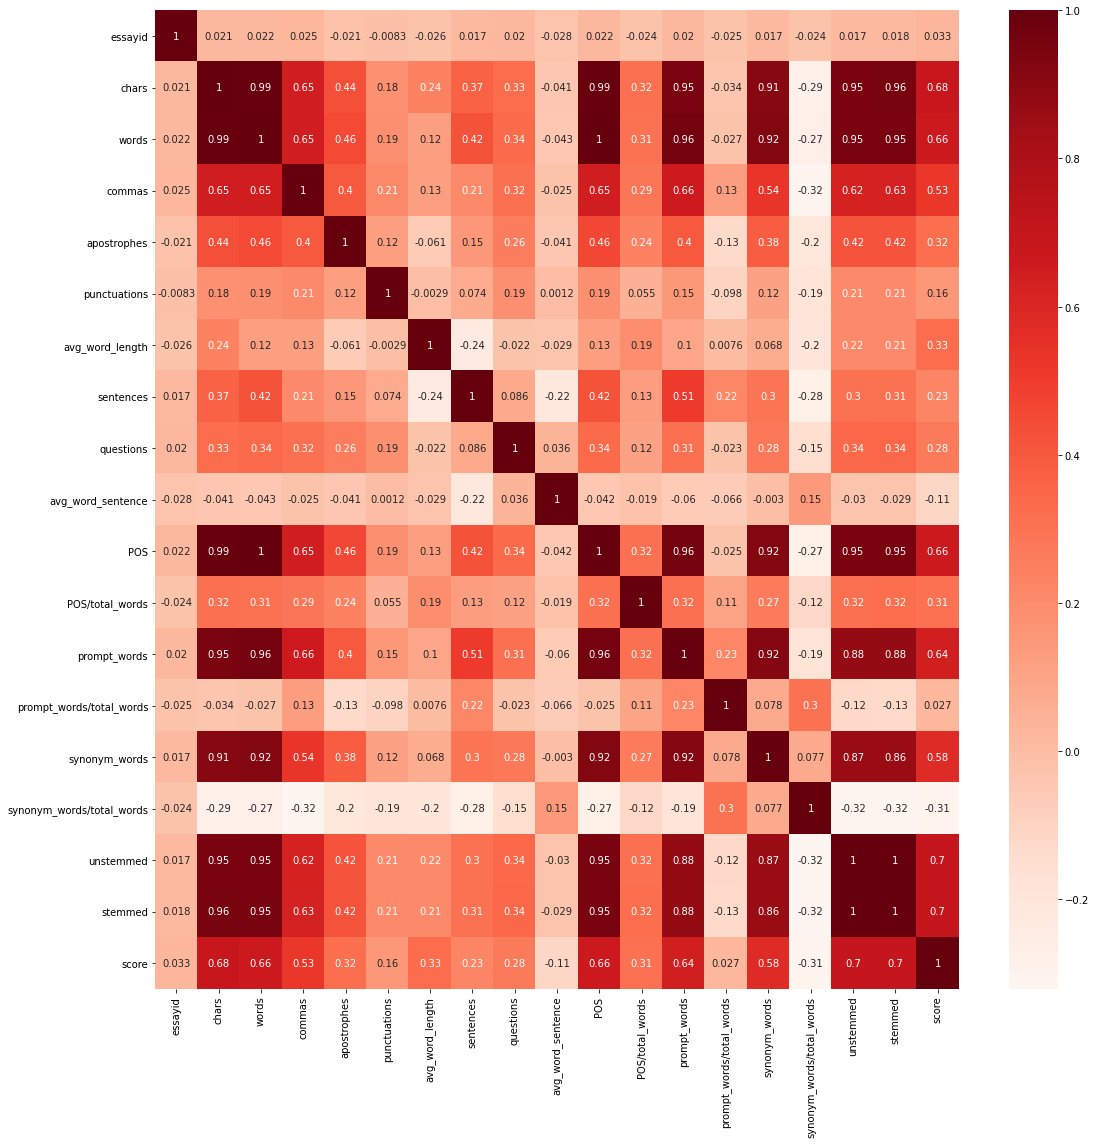

chars            0.683983
words            0.662091
commas           0.525055
POS              0.662823
prompt_words     0.641119
synonym_words    0.578352
unstemmed        0.697187
stemmed          0.696776
score            1.000000
Name: score, dtype: float64

In [ ]:
plt.figure(figsize=(18,18))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor['score'])
relevant_features = cor_target[cor_target > 0.5]
relevant_features

In [ ]:
keys = relevant_features.keys()
numKeys = len(keys)
for i in range(numKeys):
    for j in range(i+1, numKeys):
        co = dataset[[keys[i], keys[j]]].corr()
        if co[keys[j]][0] > 0.8:
            print(keys[i], keys[j])

chars words
chars POS
chars prompt_words
chars synonym_words
chars unstemmed
chars stemmed
words POS
words prompt_words
words synonym_words
words unstemmed
words stemmed
POS prompt_words
POS synonym_words
POS unstemmed
POS stemmed
prompt_words synonym_words
prompt_words unstemmed
prompt_words stemmed
synonym_words unstemmed
synonym_words stemmed
unstemmed stemmed


Supervised learning relates to a model that learns through labelling done within the dataset. This means that instead of finding patterns on its own, the supervised learning models rely on the labels which allows creation of relations between the input and output/label and once the model is trained with these labels and data, the model can predict labels for inputs. Labelled data could be anything as long as it provides objective labels such as names of animals, cars or in this case score ranging from 1-6. Training dataset is used to train the model with the labels and test dataset is used to evaluate the metrics related to the model by predicting the labels.

The label is maintained in the last column of the dataset while the input features are in the columns 1-17. The column 0 is ignored considering it contains the id of essays which has no impact on the final score.

In [ ]:
X = dataset.iloc[:, [1, 2, 10, 16]].values
y = dataset.iloc[:, 18].values

Using <b>train_test_split</b> function, a training and testing dataset is created. The <b>test_size</b> is kept to be 0.2 which also means that 80% of the dataset will be used for training while 20% will be used for testing. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.20, random_state=28888286
)

## 3. Classification

Binary classification refers to a classification model trained using only two labels so each set of features can be labelled as either the first label or the second label. However, multi-class classification refers to a model that could translate and divide features into more than two classes or labels. The model implemented in this assignment is multi-class classification.

As mentioned earlier, for some columns the mean values were much larger compared to other columns. This means that for columns that contain higher values, the influence they have over the final label would be higher. Hence, in order to ensure that there is no bias towards one column, the data is normalised such that the data for each column fits a certain range that is common for each column. The process of transforming this data is called normalisation is extremely important in this case.

In [ ]:
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Describe SVM (in relation to Linear Regression).  Again,this is not in your lecture content, you need to do some self-learning.

Support Vector Machine or SVM is a learning algorithm that is used to solve classification and regression problems, unlike Linear Regression which is used solely for regression problems. Both of them contain some major differences that make each one unique and suitable for different situations. SVM utilises vectors to identify the decision boundary that can be used to classify features into different labels, whereas Linear Regression uses a loss function and gradient descent to minimise this loss function which helps identify the relationship between the features and labels. This also means that SVM uses geometric properties compared to Linear Regression that makes use of statistical properties.

In SVM/SVR, kernel identifies a set of mathematical functions that can be used to transform the data. It is used to idenfity the inner product of the features to identify similarity between the records. These similarities and differences allow the model to make predictions and identify the labels that correspond to the features.

In [ ]:
# Reference: https://aneesha.medium.com/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

def svc_param_selection(X, y):
    param_grid = param = {'kernel' : ('linear', 'rbf', 'sigmoid', 'poly'),
                          'C' : [1,52,10],
                          'degree': [3,8],
                          'coef0' : [0.001, 10, 0.5],
                         'gamma': ("auto", "scale")}
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

This function can be used to identify the most suitable parameter values for the SVR. However, running the function with this many parameters takes a lot of time considering it goes through each iteration to find out what the best parameters would be so I would say that given it increases the efficiency of the model in the long-run, it is worth the time in the short-run.

In [ ]:
params = svc_param_selection(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   59.0s


In [ ]:
params

{'C': 52, 'coef0': 0.001, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

Using the <b>SVR</b> function, a SVR model is created and then trained using the <b>X_train</b> and <b>y_train</b> values.

In [ ]:
regressor = SVR(kernel=params['kernel'],
                C=params['C'],
                gamma=params['gamma'])
                #coef0=params['coef0'],
                #degree=params['degree']
regressor.fit(X_train, y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

The SVR model is then used to predict the labels. However, since the labels can be floats as well or could correspond to any value within the range of 1-6, the predicted labels are rounded to the nearest integer value.

In [ ]:
y_pred = regressor.predict(X_test)
y_pred = y_pred.round().astype(int)

<b>confusion_matrix</b> is used to generate a confusion matrix.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 0,  1,  0,  1,  0,  0],
       [ 1, 11, 12,  0,  0,  0],
       [ 0,  0, 81, 39,  0,  0],
       [ 0,  0, 17, 90,  2,  0],
       [ 0,  0,  0,  8,  2,  0],
       [ 0,  0,  0,  2,  0,  0]])

The confusion matrix looks very confusing and hence matplotlib is used to plot the confusion matrix to make it easier to understand.

In [ ]:
#Reference: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.xticks(np.arange(0.5, 6.5, step=1), [1,2,3,4,5,6])
plt.yticks(np.arange(0.5, 6.5, step=1), [1,2,3,4,5,6])
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False,
                top = False, labeltop=True)
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');

Explain Quadratic Weighted Kappa (QWK).  Again, this is not in yourlectures

Quadratic Weighted Kappa or QWK is a metric used to evaluate learning algorithms such as SVR. The metric identifies the agreement between predicted and actual labels. This is usually done in the range of 0-1 with 0 meaning that the model is labelling the features randomly while 1 means that the model was able to label the features perfectly. If the model is worse than random, the value of QWK can also go below 0. Generally, a QWK value of 0.6+ is preferred. However, understanding that the model did not have a large number of records to train on, the QWK value achieved is around 0.5.

In [ ]:
cohen_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(cohen_score)

<b>accuracy_score</b> function is used to evaluate the accuracy of the model.

In [ ]:
score = accuracy_score(y_test, y_pred)
score

## 4. Kaggle Submission

The same parameters as before are used to generate a new model. The reason a new model is generated is because the last model was trained using only 80% of the entire dataframe. However, in order to achieve the best model, the model is now trained on 100% of the dataframe.

Once training is done, the model is used to predict the scores for each essay maintained in the kaggle file: FIT1043-Essay-Features-Submission.csv.

In [ ]:
kaggle_dataset = pd.read_csv('FIT1043-Essay-Features-Submission.csv')
X_kaggle = kaggle_dataset.iloc[:, 1:18].values

sc = StandardScaler()
X_kaggle = sc.fit_transform(X_kaggle)
X = sc.fit_transform(X)

regressor = SVR(kernel=params['kernel'],
                C=params['C'],
                gamma=params['gamma'],
                coef0=params['coef0'],
                degree=params['degree'])
regressor.fit(X, y)

y_kaggle_pred = regressor.predict(X_kaggle)
y_kaggle_pred = y_kaggle_pred.round()

Lastly, a dataframe is created using the first column of the kaggle dataset which contains the essay ids and the predicted scores.

In [ ]:
kaggle_sub_data = {
    'essayid': kaggle_dataset.iloc[:, 0].values,
    'score': y_kaggle_pred.astype(int)
}

kaggle_sub_df = pd.DataFrame(kaggle_sub_data, columns=['essayid', 'score'])

The dataframe is then saved as a csv file, ready to be uploaded to the Kaggle site.

In [ ]:
kaggle_sub_df
kaggle_sub_df.to_csv(r'28888286-Taaha Waseem-v2.csv', index = False)

## 5. Conclusion

In conclusion, the model was able to achieve QWK of approximately 0.5 and accuracy of around 0.7. However, since the model was trained on 100% of the data instead of 80%, the model might be able to achieve a better score for the Kaggle competition. Different models can also be used in order to achieve better scores such as Random Forest, Logistic Regression or Decision Trees.

## 6. References

1. https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16 <br>
2. https://www.analyticsvidhya.com/blog/2020/12/beginners-take-how-logistic-regression-is-related-to-linear-regression/ <br>
3. https://data-flair.training/blogs/svm-kernel-functions/ <br>
4. https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps <br>
5. https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a <br>
6. https://aneesha.medium.com/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0